# Import

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import pickle 
import joblib

from pprint import pprint
from tqdm import tqdm

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, minmax_scale

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.datasets import load_digits

from tensorflow.keras.callbacks import ModelCheckpoint

from scipy.ndimage import convolve

from keras.utils import to_categorical

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

import collections 
import random

# Data Preparation

In [3]:
FULL_DATA = False
LE = LabelEncoder()
WINDOW_LENGTH = 7
DATA_MULTIPLIER = 1
ADD_ELEMENTS = True
RETAIN_RATIO = True

In [ ]:
concatenated_data = pd.read_csv("Concatenated Data.csv")

raw_dataset = concatenated_data[["temp", "feelslike", "humidity", "windspeed", "sealevelpressure", "conditions"]]

# raw_dataset["raw_conditions"] = raw_dataset["conditions"]
raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])

t_arr = raw_dataset.copy().to_numpy()
X = []
y = []

for i in range(len(t_arr) - WINDOW_LENGTH):
    t_row = []
    for j in t_arr[i : i + WINDOW_LENGTH]:
        t_row.append(j[:-1])
    t_row = np.array(t_row).flatten()
    X.append(t_row)
    y.append(t_arr[i + WINDOW_LENGTH][-1])

X = np.array(X, "float32")
X = minmax_scale(X, feature_range=(0, 1))
y = np.array(y)

counts = dict(collections.Counter(y))
max_count = max(counts.values())

# Data Augmentation

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X, y, test_size = 0.2, random_state=828)
X_orig_train, X_orig_valid, y_orig_train, y_orig_valid = train_test_split(X_orig_train, y_orig_train, test_size = 0.2, random_state=828)

if ADD_ELEMENTS:
    for key, value in counts.items():
        curX = []
        curY = []
        li, = np.where(y == key)
        if not RETAIN_RATIO:
            for i in range((max_count - value) * DATA_MULTIPLIER):
                ci = random.choice(li)
                curX.append(X[ci])
                curY.append(y[ci])
        else:
            for i in range(value * DATA_MULTIPLIER):
                ci = random.choice(li)
                curX.append(X[ci])
                curY.append(y[ci])

        tX = X.tolist()
        tY = y.tolist()
        tX.extend(curX)
        tY.extend(curY)
        X = np.array(tX)
        y = np.array(tY)        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=828)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=828)

print(X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_valid.shape, y_test.shape)


(4344, 35) (1358, 35) (1086, 35) (4344,) (1086,) (1358,)


C:\Users\Alaric\AppData\Local\Temp\ipykernel_3956\2416956651.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = raw_dataset["conditions"].replace(
C:\Users\Alaric\AppData\Local\Temp\ipykernel_3956\2416956651.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
C:\Users\Alaric\AppData\Local\Temp\ipykernel_3956\2416956651.py:16: SettingWithCopyWarning: 
A value i

# Implement : DBN + RFC

In [ ]:
MLPipeline = Pipeline([
    ("[DBN] RBM 1", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 100, verbose = 0)),
    ("[DBN] RBM 2", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 100, verbose = 0)),
    ("[DBN] RBM 3", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 100, verbose = 0)),
    ("[DBN] RBM 4", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 100, verbose = 0)),
    ("[DBN] RBM 5", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 100, verbose = 0)),
    # ("RandomForestClassifier", RandomForestClassifier(class_weight='balanced'))
    ("RandomForestClassifier", RandomForestClassifier(random_state=828))
])

MLPipeline.fit(X_train, y_train)
joblib.dump(MLPipeline, 'FinalRFCModel.pkl')


['FinalRFCModel.pkl']

In [11]:
MLPipeline = joblib.load("FinalRFCModel.pkl")

In [14]:
y_pred = MLPipeline.predict(X_train)
accuracy_score(y_train, y_pred) * 100

96.89226519337016

In [15]:
y_pred = MLPipeline.predict(X_test)
accuracy_score(y_test, y_pred) * 100

88.07069219440353

In [16]:
print(classification_report(y_test, y_pred, target_names=LE.classes_, digits=4))

              precision    recall  f1-score   support

      Cloudy     1.0000    1.0000    1.0000         8
       Rainy     0.8611    0.8730    0.8670       575
       Sunny     0.8947    0.9203    0.9073       665
       Windy     0.8916    0.6727    0.7668       110

    accuracy                         0.8807      1358
   macro avg     0.9118    0.8665    0.8853      1358
weighted avg     0.8808    0.8807    0.8794      1358



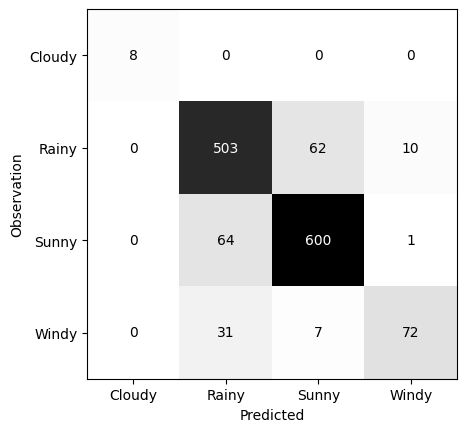

In [ ]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = LE.classes_).plot(cmap="binary").im_.colorbar.remove()
plt.xlabel("Predicted")
plt.ylabel("Observation")
plt.show()